In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import normalized_mutual_info_score as NMI

# import graphical lasso
from sklearn.covariance import GraphicalLasso

%matplotlib inline

In [2]:
import sys
sys.path.insert(1, "../utilities")
from plot_utils import *
from extract import *
from assigners import *
from effect_estimators import *
from VAT_simple import *
from MF import *
from graphs import *
#from experimental import *

In [3]:
def get_masstimes(mass_time, inds=None):
    if inds is None:
        inds = np.arange(mass_time.shape[0])
    masstime = np.empty((len(inds),), dtype=object)
    for i, ind in enumerate(inds):
        masstime[i]=mass_time[ind,0] + "@" + mass_time[ind,1]
    return masstime


def map_cluster_ids(df, df_cluster, mt_col=' masstime', c_col=' clusterID'):
    df_new=df.copy()
    for row in range(df_new.shape[0]):
        mt = df_new.loc[row,mt_col]
        ind = np.where(df_cluster[mt_col]==mt)[0]
        label = df_cluster.loc[ind,c_col].values
        df_new.at[row,c_col] = label
    return df_new

def get_negatively_correlated_clusters(df, cluster_id = 'clusterID', th=0.75, min_size=2):
    df_new = df.copy()
    labels = df_new[cluster_id].to_numpy()
 
    luniq = np.unique(labels)
    lcounts = np.zeros((len(luniq),))
    for i, l in enumerate(luniq):
        lcounts[i] = np.where(labels==l)[0].shape[0]
    dict_clusters = dict(zip(luniq, lcounts))
    
    list_singular_vectors = []
    for i, label in enumerate(luniq):
        inds = np.where(labels==label)[0]
        cluster = df_new.iloc[inds,9:].to_numpy(dtype=float).T
        if cluster.shape[1] > 1:
            # represent the cluster with first singular vector
            # shift and scale the cluster to [0,1]
            #cluster = (cluster - np.min(cluster))/(np.max(cluster)-np.min(cluster))
            u, s, vh = np.linalg.svd(cluster, full_matrices=False)
            #u_init,v_init=nnd_svd_initialization(cluster, 2)
            #u, v, err = matrix_factorization(cluster, u_init, v_init, n_iter=1000, n_iter_inner=10, alpha=0.0002, beta=0.02)
            if np.corrcoef(u[:,0], cluster[:,0])[0,1] < 0:
                cluster = -u[:,0]
            else:
                cluster = u[:,0]
        else:
            cluster=cluster.reshape(-1,)
            # shift and scale the cluster to [0,1]
            #cluster = (cluster - np.min(cluster))/(np.max(cluster)-np.min(cluster))
        
        list_singular_vectors.append(cluster)
    dict_singular_vectors = dict(zip(luniq, list_singular_vectors))
    
    # create a dictionary of clusters, where keys are cluster labels
    # and values are labels of clusters that are negatively correlated.
    # The correlations are calculated between the first singular vectors
    # of the clusters.
    dict_neg_correlated = {}
    for i in dict_singular_vectors.keys():
        if dict_neg_correlated.get(i) is None:
            dict_neg_correlated[i] = []
        
        for j in dict_singular_vectors.keys():
            if i==j or j in dict_neg_correlated[i] or dict_clusters[j] < min_size:
                continue    
            else:
                corr = np.corrcoef(dict_singular_vectors[i], dict_singular_vectors[j])[0,1]
                if corr < -th:
                    dict_neg_correlated[i].append(j)
                    if dict_neg_correlated.get(j) is None:
                        dict_neg_correlated[j] = []
                    dict_neg_correlated[j].append(i)
                    
    ss=[]
    for key in dict_neg_correlated.keys():
        s=''
        for i, elem in enumerate(dict_neg_correlated[key]):
            if i==0:
                s += str(elem)
            else:
                s += ',' + str(elem)
         
        ss.append(s)      
        #dict_neg_correlated[key] = s
    #return dict_neg_correlated
    return dict(zip(dict_neg_correlated.keys(), ss))


In [4]:
#fnum=2
fnum=1


# Data
pathGF = "../../../PARKINSONS/PDproj/celldata/datawithGFstatus/clean/"
filenamesGF = [line.split('\n')[0] for line in open(pathGF + "filenames.txt")]
print(filenamesGF[fnum])
df_GF = pd.read_csv(pathGF + filenamesGF[fnum],sep=';', header=None)

# Significance information
path_s = "../../../PARKINSONS/PDproj/cellresults/ttest/withGF/only32/ALPHA0.05FC1.0MINVAR0.125/"
filenames_s = [line.split('\n')[0] for line in open(path_s + "filenames.txt")]
print(filenames_s[fnum])
df_s = pd.read_csv(path_s + filenames_s[fnum],sep=';')

path_out = "../../../PARKINSONS/PDproj/cellresults/ttest/withGF/only32/ALPHA0.05FC1.0MINVAR0.125/experimental/"

tle = filenamesGF[fnum].split('GF')[0]

masstime = np.unique(df_s[' masstime'].to_numpy())
data_significant=get_features(masstime, df_GF, True,[0,1,2])

Area = data_significant.iloc[3:,8:48]
groups = df_GF.iloc[0,8:48]
labels = LabelEncoder().fit_transform(groups)

data_X=data_significant.iloc[3:,:48]

cellshilicposGFstatus.csv
cellshilicposALPHA0.05FC1.0MINVAR0.125.csv


In [5]:
#sorted_ind=np.argsort(data_significant.iloc[3:,5])
#data_significant=data_significant.iloc[sorted_ind+3,:]
data_X.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
4,Acetyl-L-carnitine,C9 H17 N O4,0.8,203.11592,204.1232,2.791,DDA for preferred ion,[M+H]+1,26.82393260341057,26.966564272710535,...,27.00958446663517,26.175660481045096,26.337087683150937,26.98083288192512,26.268390416994002,26.75509093347562,26.140621104078676,25.935005024668087,26.53331967511474,27.241647167276135
12,Nicotinamide,C6 H6 N2 O,2.49,122.04832,123.05559,0.665,No MS2,[M+H]+1,22.006117213600273,22.07771837617395,...,21.44874170776048,20.892732577090673,21.011685174193946,20.49273814660585,20.119465402295802,20.59623573625013,20.915410009242553,19.988197892652014,20.61072606271381,21.000883718098475
13,L-Glutathione (reduced),C10 H17 N3 O6 S,-0.28,307.08372,308.091,6.716,DDA for preferred ion,[M+H]+1,22.980586387914823,23.341197403517477,...,23.084066313282808,24.114733602540284,23.526077976628528,23.29804877105999,23.517500499611373,22.975228866295897,24.032879751060328,24.18408174950941,23.525485654380283,23.67324274041142
19,Proline,C5 H9 N O2,3.14,115.06369,116.07097,4.86,DDA for preferred ion,[M+H]+1,25.08265695723885,25.17512571851284,...,24.667349852883664,24.60242156555858,25.00842568545393,24.173943533794528,24.64533651674489,24.188904615750484,24.799650877629926,24.514525827756504,24.11476045200486,24.454618228491547
20,Propionylcarnitine,C10 H19 N O4,0.76,217.13157,218.13885,1.987,DDA for preferred ion,[M+H]+1,24.71145791615756,24.97910778381518,...,24.80905268125279,24.49982693555186,24.582705537333887,24.73700444172097,24.312168928803047,24.340203997795825,24.56199870070008,24.486453940469485,24.986292334202286,24.96862772843322


### Correlation distance CD $\in$ [0,2]

**Value 0 corresponds to fully positively correlated features (cor=1), value 2 fully negatively correlated features (cor=-1). Values close to 1 are uncorrelated.**

In [6]:
X=data_X.iloc[:,8:].to_numpy(dtype=float).T

# Correlation matrix with ddof=0 (just holding a fixed rule)
stdsc = StandardScaler() 
X_std = stdsc.fit_transform(X)
COR = np.cov(X_std.T, ddof=1)

# clip the correlation matrix, to only include correlations above a certain threshold
COR[COR<0.95]=0

# Make a distance matrix from the correlation matrix COR
#mask = np.ones_like(COR) # change mask e.g., to account for temporal proximity
#CD = 1 - mask*COR
CD = 1 - COR
# make sure the diagonal is zero and the matrix is PD
CD = np.maximum(CD, CD.T)
CD -= np.diag(CD.diagonal())
CD = np.clip(CD,0,2)
cd_matrix = squareform(CD,force='tovector')

print(tle, 'data has',X.shape[1], ' features')
print('\nRange of values in cor-dist:', CD.min(),'-',np.round(CD.max(),2))

cellshilicpos data has 58  features

Range of values in cor-dist: 0.0 - 1.0


In [126]:
glasso = GraphicalLasso(alpha=0.15, max_iter=1000)
glasso.fit(X_std)

GraphicalLasso(alpha=0.15, max_iter=1000)

In [136]:
# cross validate the alpha parameter for graphical lasso
alphas = np.linspace(0.1, 0.25, 5)
for alpha in alphas:
    glasso = GraphicalLasso(alpha=alpha, max_iter=1000)
    glasso.fit(X_std)
    print('alpha:', alpha, 'score:', glasso.score(X_std))


alpha: 0.1 score: -6.531996764552668
alpha: 0.1375 score: -7.326867882058302
alpha: 0.175 score: -7.975053854926566
alpha: 0.2125 score: -8.523247530284644
alpha: 0.25 score: -9.006378469638182


In [131]:
cov = glasso.covariance_
CD = 1 - cov
CD -= np.diag(CD.diagonal())

### A rough visualization of clustering tendency based on cor-dist

**Can typically recognize 2 main structures corresponding to typical test patterns: typically majority of the form (aSYN,UT) low, (IFNg, comb) high, and minority (aSYN,UT) high, (IFNg, comb) low. These two patterns are negatively correlated.**

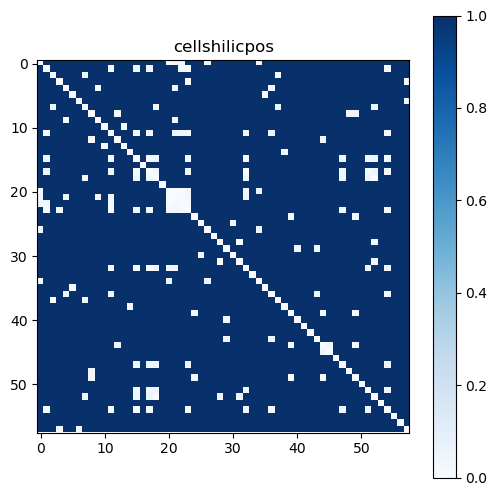

In [7]:
plt.figure(figsize=(6,6))
plt.imshow(CD, cmap='Blues')
plt.colorbar()
plt.title(tle)
plt.show()

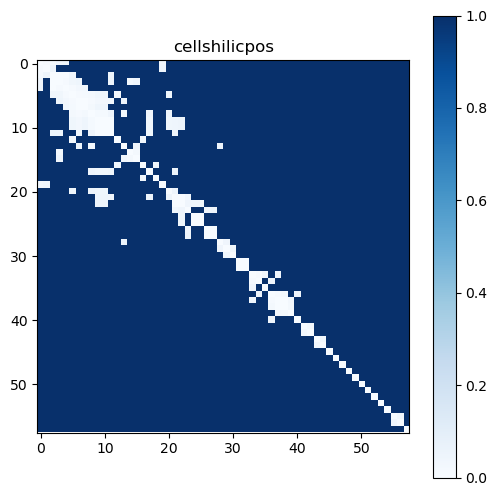

In [8]:
plt.figure(figsize=(6,6))
plt.imshow(VAT(CD), cmap='Blues')
plt.colorbar()
plt.title(tle)
plt.show()
#pyclustertend.vat(CD, figure_size=(6,6))
#plt.title(tle)
#plt.show()

In [155]:
def show_graph_with_labels(adjacency_matrix, names, lim,title=''):
    adjacency_matrix += lim*np.eye(adjacency_matrix.shape[0])
    rows, cols = np.where(adjacency_matrix < lim)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()#.DiGraph()
    gr.add_nodes_from(range(adjacency_matrix.shape[0]))
    gr.add_edges_from(edges)
    ##
    #pos = nx.spring_layout(gr, scale=1, k=1/np.sqrt(adjacency_matrix.shape[0]))
    pos = nx.spring_layout(gr, k=0.15, iterations=15)
    plt.figure()
    #nx.draw(gr, node_size=50, labels=names, with_labels=True)
    if names is None:
        nx.draw(gr, pos, edge_color='black', width=2, linewidths=1,\
            node_size=50, node_color='blue', alpha=0.9, with_labels=False)
    else:
        nx.draw(gr, pos, edge_color='black', width=1, linewidths=1, font_size=6, font_color='black', \
                    node_size=120, node_color='red', alpha=0.9,\
                labels={node:names[node] for node in gr.nodes()}, with_labels=True)
    plt.title(title)
    plt.show()

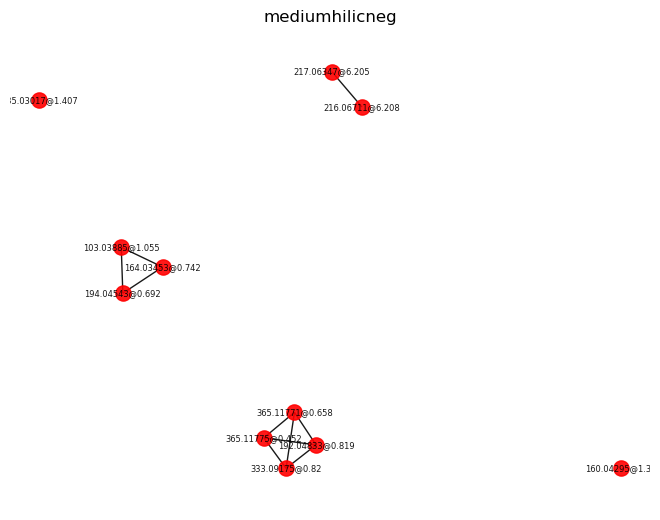

In [156]:
show_graph_with_labels(CD, masstime, .5, tle)
#show_graph_with_labels(CD, None, .05, tle)


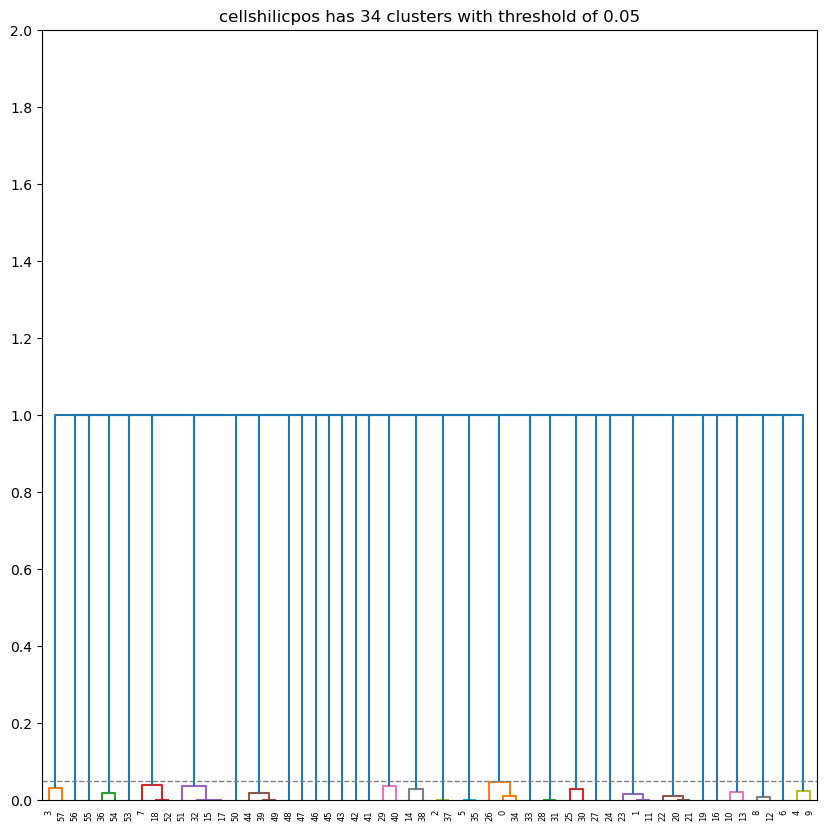

In [9]:
th=0.05
plt.figure(figsize=(10,10))
link_complete = hierarchy.linkage(cd_matrix, method='complete',  optimal_ordering=False)
labels_complete=hierarchy.fcluster(link_complete, t=th, criterion='distance')
hierarchy.dendrogram(link_complete, truncate_mode='none', labels=np.asarray(np.arange(CD.shape[0])))
plt.axhline(y=th, c='grey', lw=1, linestyle='dashed')
plt.yticks(np.arange(0,2.1,0.2))
plt.title("{} has {} clusters with threshold of {}".format(tle, np.unique(labels_complete).shape[0], th))
plt.show()

In [10]:
luniq = np.unique(labels_complete)
len(luniq)

34

In [11]:
# just the significant features
data_with_labels = data_X.copy()
data_with_labels.insert(1, ' clusterID', labels_complete)
#data_with_labels.sort_values(by=[' clusterID'], inplace=True)

# add a column to the dataframe that indicates to which, if any, cluster is negatively correlated
dict_neg_correlated = get_negatively_correlated_clusters(data_with_labels, cluster_id = ' clusterID', th=0.9, min_size=1)
neg_correlated = np.empty((data_with_labels.shape[0],), dtype=object)
for row in range(data_with_labels.shape[0]):
    label = data_with_labels.iloc[row,1]
    neg_correlated[row] = dict_neg_correlated[label]

data_with_labels.insert(2, ' neg_cor_clusters', neg_correlated)

In [12]:
neg_correlated

array(['', '32', '', '', '', '', '', '', '', '', '', '32', '', '', '32',
       '', '', '', '', '', '', '', '', '32', '', '', '', '', '', '', '',
       '', '', '', '', '', '32', '', '32', '', '', '', '', '32', '', '32',
       '', '', '', '', '', '', '', '2,7,13,26,27', '32', '', '', ''],
      dtype=object)

In [13]:
data_with_labels.head()

,0,clusterID,neg_cor_clusters,1,2,3,4,5,6,7,...,38,39,40,41,42,43,44,45,46,47
4,Acetyl-L-carnitine,10,,C9 H17 N O4,0.8,203.11592,204.1232,2.791,DDA for preferred ion,[M+H]+1,...,27.00958446663517,26.175660481045096,26.337087683150937,26.98083288192512,26.268390416994002,26.75509093347562,26.140621104078676,25.935005024668087,26.53331967511474,27.241647167276135
12,Nicotinamide,13,32,C6 H6 N2 O,2.49,122.04832,123.05559,0.665,No MS2,[M+H]+1,...,21.44874170776048,20.892732577090673,21.011685174193946,20.49273814660585,20.119465402295802,20.59623573625013,20.915410009242553,19.988197892652014,20.61072606271381,21.000883718098475
13,L-Glutathione (reduced),8,,C10 H17 N3 O6 S,-0.28,307.08372,308.091,6.716,DDA for preferred ion,[M+H]+1,...,23.084066313282808,24.114733602540284,23.526077976628528,23.29804877105999,23.517500499611373,22.975228866295897,24.032879751060328,24.18408174950941,23.525485654380283,23.67324274041142
19,Proline,1,,C5 H9 N O2,3.14,115.06369,116.07097,4.86,DDA for preferred ion,[M+H]+1,...,24.667349852883664,24.60242156555858,25.00842568545393,24.173943533794528,24.64533651674489,24.188904615750484,24.799650877629926,24.514525827756504,24.11476045200486,24.454618228491547
20,Propionylcarnitine,17,,C10 H19 N O4,0.76,217.13157,218.13885,1.987,DDA for preferred ion,[M+H]+1,...,24.80905268125279,24.49982693555186,24.582705537333887,24.73700444172097,24.312168928803047,24.340203997795825,24.56199870070008,24.486453940469485,24.986292334202286,24.96862772843322


In [14]:
data_with_labels.iloc[:,5]

4      203.11592
12     122.04832
13     307.08372
19     115.06369
20     217.13157
21     117.07932
23      89.04817
24     446.37608
25     702.56748
28     245.16278
65     145.11043
69     122.04834
88     704.58309
90     117.05419
93     231.14717
94     495.42873
105     717.5671
106    478.40211
157     462.3708
158    219.11081
166      243.147
169    261.15763
190    145.08529
200      247.142
212    297.08954
225    741.56709
235    203.11594
244    348.04693
245    436.35507
253     143.0948
269    741.56652
275    418.34459
303     404.3657
318    493.31668
323    203.11589
331    175.13226
343    218.10567
346    178.04133
350    674.53591
351    719.54621
375    143.09482
386    674.53619
388    147.05331
391    208.08501
396    745.56112
403    745.56208
407    715.55143
420    299.11334
426    521.34811
427    719.54572
433    715.55092
444    676.55129
452    836.68906
455    204.08997
472    559.07156
487     84.02163
491    511.30978
494     126.0432
Name: 3, dtype

In [135]:
np.where(data_X.iloc[:,4]=='830.55384')

(array([], dtype=int64),)

In [65]:
# collect feature 830.55384@16.832
print(data_X.iloc[np.where(data_X.iloc[:,4]=="830.55384")[0],7])
#" same for "762.566"
print(data_X.iloc[np.where(data_X.iloc[:,4]=="762.566")[0],7])
# collect feature 830.55384@16.832
print(data_X.iloc[np.where(data_X.iloc[:,4]=="830.55384")[0],6])
#" same for "762.566"
print(data_X.iloc[np.where(data_X.iloc[:,4]=="762.566")[0],6])
# collect feature 830.55384@16.832
print(data_X.iloc[np.where(data_X.iloc[:,4]=="830.55384")[0],2])
#" same for "762.566"
print(data_X.iloc[np.where(data_X.iloc[:,4]=="762.566")[0],2])

706    [M-H]-1
Name: 7, dtype: object
432    [M-H]-1
Name: 7, dtype: object
706    DDA for preferred ion
Name: 6, dtype: object
432    DDA for preferred ion
Name: 6, dtype: object
706    -0.48
Name: 2, dtype: object
432    -1.52
Name: 2, dtype: object


### Compile the assignments and update the dataframe with significant features

In [15]:
# Make a copy of the significance data
df_temp=df_s.copy()

df_temp.insert(1, ' clusterID', np.zeros((df_s.shape[0]),dtype=int))
df_temp.insert(2, ' neg_cor_clusters', np.empty((df_s.shape[0]),dtype=object))

# Make cluster assignment dataframe
clustered_features = pd.DataFrame({' masstime':get_masstimes(data_X.iloc[:,4:6].to_numpy()),
                                   ' clusterID':labels_complete})
# Do the same with negative correlation information
clustered_features_neg = pd.DataFrame({' masstime':get_masstimes(data_X.iloc[:,4:6].to_numpy()),
                                      ' neg_cor_clusters':neg_correlated})

In [17]:
check=clustered_features.join(clustered_features_neg.set_index(' masstime'), on=' masstime')
check.sort_values(by=[' clusterID'], inplace=True)
check.head(10)

,masstime,clusterID,neg_cor_clusters
57,127.05048@5.447,1,
3,116.07097@4.86,1,
54,560.07883@7.739,2,32
36,219.11294@0.719,2,32
52,419.35181@0.381,3,
18,463.37813@0.386,3,
7,447.38325@0.374,3,
32,405.3727@0.378,4,
51,677.55857@0.874,4,
17,496.436@0.373,4,


In [165]:
# Map the assignments and make a new dataframe
df_new=map_cluster_ids(df_temp, clustered_features, mt_col=' masstime', c_col=' clusterID')
df_new=map_cluster_ids(df_new, clustered_features_neg, mt_col=' masstime' , c_col=' neg_cor_clusters')
df_new.sort_values(by=[' clusterID'], inplace=True)

In [166]:
df_new.head()

,compound,clusterID,neg_cor_clusters,masstime,test,p_orig,p_FDR,p_Bonf,FC,ms,gaps1,gaps2
0,NaN,1,,365.11775@0.452,aSYN--UT,0.000000e+00,9.000000e-14,4.000000e-14,-4.319813,2.916931,0,0
21,"3,3-Dimethyl-7-oxo-6-[(phenylacetyl)amino]-4-t...",1,,333.09175@0.82,aSYN--UT,3.878700e-10,3.233281e-08,1.136461e-07,-4.172405,3.545848,10,0
22,"2,3-DIHYDRO-2-METHYL-1,5-BENZOTHIAZEPIN-4(5H)-ONE",1,,192.04833@0.819,comb.--UT,6.832700e-10,5.448088e-08,2.001983e-07,-4.007154,3.196571,10,0
12,NaN,1,,365.11771@0.658,comb.--INFg.,3.530000e-12,4.972800e-10,1.032840e-09,-4.436930,3.226920,0,0
11,NaN,1,,365.11771@0.658,aSYN--UT,1.100000e-13,1.747000e-11,3.350000e-11,-4.359323,2.836954,0,0


In [167]:
df_new.head(100)

,compound,clusterID,neg_cor_clusters,masstime,test,p_orig,p_FDR,p_Bonf,FC,ms,gaps1,gaps2
0,NaN,1,,365.11775@0.452,aSYN--UT,0.000000e+00,9.000000e-14,4.000000e-14,-4.319813,2.916931,0,0
21,"3,3-Dimethyl-7-oxo-6-[(phenylacetyl)amino]-4-t...",1,,333.09175@0.82,aSYN--UT,3.878700e-10,3.233281e-08,1.136461e-07,-4.172405,3.545848,10,0
22,"2,3-DIHYDRO-2-METHYL-1,5-BENZOTHIAZEPIN-4(5H)-ONE",1,,192.04833@0.819,comb.--UT,6.832700e-10,5.448088e-08,2.001983e-07,-4.007154,3.196571,10,0
12,NaN,1,,365.11771@0.658,comb.--INFg.,3.530000e-12,4.972800e-10,1.032840e-09,-4.436930,3.226920,0,0
11,NaN,1,,365.11771@0.658,aSYN--UT,1.100000e-13,1.747000e-11,3.350000e-11,-4.359323,2.836954,0,0
10,NaN,1,,365.11771@0.658,aSYN--INFg,2.000000e-14,3.860000e-12,6.780000e-12,-4.696145,3.485410,0,0
23,"2,3-DIHYDRO-2-METHYL-1,5-BENZOTHIAZEPIN-4(5H)-ONE",1,,192.04833@0.819,aSYN--UT,8.027500e-10,6.134068e-08,2.352060e-07,-4.036855,3.286736,10,0
20,"3,3-Dimethyl-7-oxo-6-[(phenylacetyl)amino]-4-t...",1,,333.09175@0.82,comb.--UT,3.186100e-10,2.782412e-08,9.335320e-08,-4.142705,3.455683,10,0
8,"2,3-DIHYDRO-2-METHYL-1,5-BENZOTHIAZEPIN-4(5H)-ONE",1,,192.04833@0.819,aSYN--INFg,0.000000e+00,4.200000e-13,6.100000e-13,-4.573910,4.093753,10,0
6,NaN,1,,365.11775@0.452,comb.--INFg.,0.000000e+00,1.600000e-13,1.800000e-13,-4.337010,2.883526,0,0


### Write new results

In [371]:
#df_new.to_csv(path_out + fname, sep=';', index=None)

### Checks

In [168]:
data_with_labels.head(10)

,0,clusterID,neg_cor_clusters,1,2,3,4,5,6,7,...,38,39,40,41,42,43,44,45,46,47
7,Fluoro(dimethyl)vinylsilane,3,,C4 H9 F Si,3.53,104.04612,103.03885,1.055,DDA for preferred ion,[M-H]-1,...,19.129797288833306,19.01994648824205,19.14154436712777,18.837065665771416,19.0589642756007,18.870286743442662,19.11393637502026,18.994825617392205,18.818501449130196,18.846881156522645
28,Allopurinol,4,,C5 H4 N4 O,-7.81,136.03745,135.03017,1.407,DDA for preferred ion,[M-H]-1,...,20.844436850024938,20.13425057871037,20.367215997854345,20.521463108481186,20.268825748870576,20.7303262427129,20.143963329379453,20.00073167542378,20.680042935018903,20.825750365527757
35,NaN,5,,NaN,NaN,161.05023,160.04295,1.36,DDA for preferred ion,[M-H]-1,...,19.564028909732237,18.22503226833798,17.450288846774562,19.450260338073264,18.422169266595674,19.296413506320302,18.327520322724617,18.321621534125388,19.253920961757018,19.159859877506534
36,"1H-Indole-2,3,4-triol",3,,C8 H7 N O3,-4.74,165.04181,164.03453,0.742,DDA for preferred ion,[M-H]-1,...,12.636430388526481,13.21113181324201,12.773826189364575,12.509782727009787,12.724594678711911,13.0056011270051,13.321711687978098,13.483037851285427,12.747974037952268,12.621333557115369
48,"2,3-DIHYDRO-2-METHYL-1,5-BENZOTHIAZEPIN-4(5H)-ONE",1,,C10 H11 N O S,-2.76,193.0556,192.04833,0.819,DDA for preferred ion,[M-H]-1,...,16.432520893853027,17.595548185267738,17.160013636783336,16.501037789932127,17.43094738234686,16.242059632756504,17.16701760943889,17.48787259720899,16.779466659389687,16.46039839651437
49,4-Acetamidosalicylic Acid,3,,C9 H9 N O4,-2.32,195.05271,194.04543,0.692,DDA for preferred ion,[M-H]-1,...,12.493137032242347,12.430402853055957,12.108504767520314,12.255009207639352,12.459129182217627,12.330198729834388,12.234057551075946,12.420540532664697,12.578629834672812,12.300958734421165
56,Ethyl 4-hydroxy-3-quinolinecarboxylate,2,,C12 H11 N O3,2.26,217.07438,216.06711,6.208,No MS2,[M-H]-1,...,14.645129501855338,14.782457698894039,15.049179137486423,14.300495943772743,15.163439339215465,14.402151616477932,15.244484503415432,14.838781871182759,14.537303820353268,14.745598292850007
58,Diethyl (2-furylmethyl)phosphonate,2,,C9 H15 O4 P,-0.21,218.07075,217.06347,6.205,DDA for preferred ion,[M-H]-1,...,16.753168406244694,17.073992599059064,17.11123985445248,16.66795073176065,17.25926040064277,16.538332165011393,17.182887341539903,17.04282065387252,16.571880284967577,16.894755123920586
81,"3,3-Dimethyl-7-oxo-6-[(phenylacetyl)amino]-4-t...",1,,C16 H18 N2 O4 S,0.91,334.09903,333.09175,0.82,DDA for preferred ion,[M-H]-1,...,16.568648725564124,17.701780077223944,17.34597777754554,16.6411986927924,17.556971914135964,16.535286363822344,17.294062974976875,17.556056377546152,16.90325097456399,16.500284622574508
84,NaN,1,,C18 H18 N6 O S,-3.52,366.12499,365.11771,0.658,DDA for preferred ion,[M-H]-1,...,18.112682356626735,18.286720646254555,18.420418654378633,18.107241713579878,18.34046785914348,17.8844796303324,18.604418810516655,18.269311489012434,17.390937854149865,18.106874355303106


In [127]:
s1="702.50844";t1="15.822"
s2="702.50845";t2="15.827"
s3="802.51417";t3="17.691"
s4="802.51471";t4="17.696"
s5="844.48063";t5="17.69"
s6="844.48077";t6="17.691"

['17.69' '17.691']


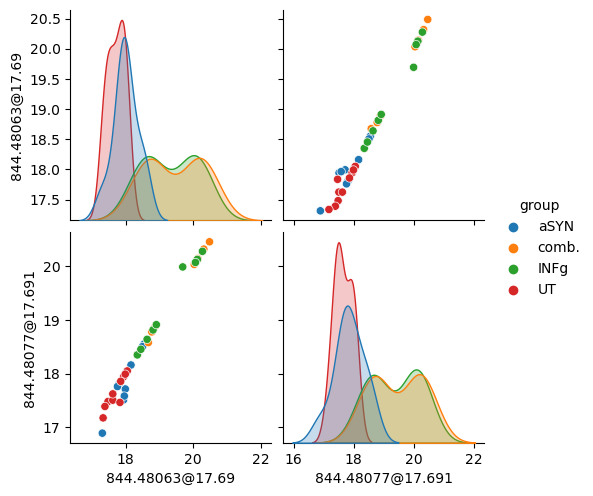

In [132]:
#b1=np.where(np.logical_and( data_with_labels.iloc[:,6]==s1, data_with_labels.iloc[:,7]==t1))[0]
#b2=np.where(np.logical_and( data_with_labels.iloc[:,6]==s2, data_with_labels.iloc[:,7]==t2))[0]
#b3=np.where(np.logical_and( data_with_labels.iloc[:,6]==s3, data_with_labels.iloc[:,7]==t3))[0]
#b4=np.where(np.logical_and( data_with_labels.iloc[:,6]==s4, data_with_labels.iloc[:,7]==t4))[0]
b5=np.where(np.logical_and( data_with_labels.iloc[:,6]==s5, data_with_labels.iloc[:,7]==t5))[0]
b6=np.where(np.logical_and( data_with_labels.iloc[:,6]==s6, data_with_labels.iloc[:,7]==t6))[0]


#cluster_inds = np.concatenate((b1,b2,b3,b4,b5,b6))
#cluster_inds = np.concatenate((b1,b2))
#cluster_inds = np.concatenate((b3,b4))
cluster_inds = np.concatenate((b5,b6))
cluster_times = data_with_labels.iloc[cluster_inds,7].to_numpy()
cluster_masses = data_with_labels.iloc[cluster_inds,6].to_numpy()
cluster_masstimes = ["{}@{}".format(cluster_masses[i], cluster_times[i]) for i in range(cluster_masses.shape[0])]

cluster = data_with_labels.iloc[cluster_inds,10:50].to_numpy(dtype=float).T
df_cluster = pd.DataFrame(cluster, columns = cluster_masstimes)
df_cluster = pd.DataFrame(cluster, columns = cluster_masstimes)
df_cluster['group']=groups.to_numpy(dtype=str)
print(cluster_times)

complete_pairplot(df_cluster, group_col='group', kind='kde', palette=None)

In [169]:
#id1, id2 = 8, 76
#id1, id2 = 0, 53
id1, id2 = 0, 1

cluster_ind = np.where(np.logical_or(data_with_labels[' clusterID']==id1,data_with_labels[' clusterID']==id2))[0]
cluster_ids = data_with_labels.iloc[cluster_ind,1].to_numpy(dtype=int)
cluster_times = data_with_labels.iloc[cluster_ind,7].to_numpy(dtype=float)
cluster_mass = data_with_labels.iloc[cluster_ind,6].to_numpy(dtype=float)
cluster_masstimes = ["{}@{} ID: {}".format(m,t,cluster_ids[i]) for i,(m,t) in enumerate(zip(cluster_mass,cluster_times))]

cluster = data_with_labels.iloc[cluster_ind,10:50].to_numpy(dtype=float).T

df_cluster = pd.DataFrame(cluster, columns = cluster_masstimes)
df_cluster = pd.DataFrame(cluster, columns = cluster_masstimes)
df_cluster['group']=groups.to_numpy(dtype=str)
print(cluster_times)

[0.819 0.82  0.658 0.452]


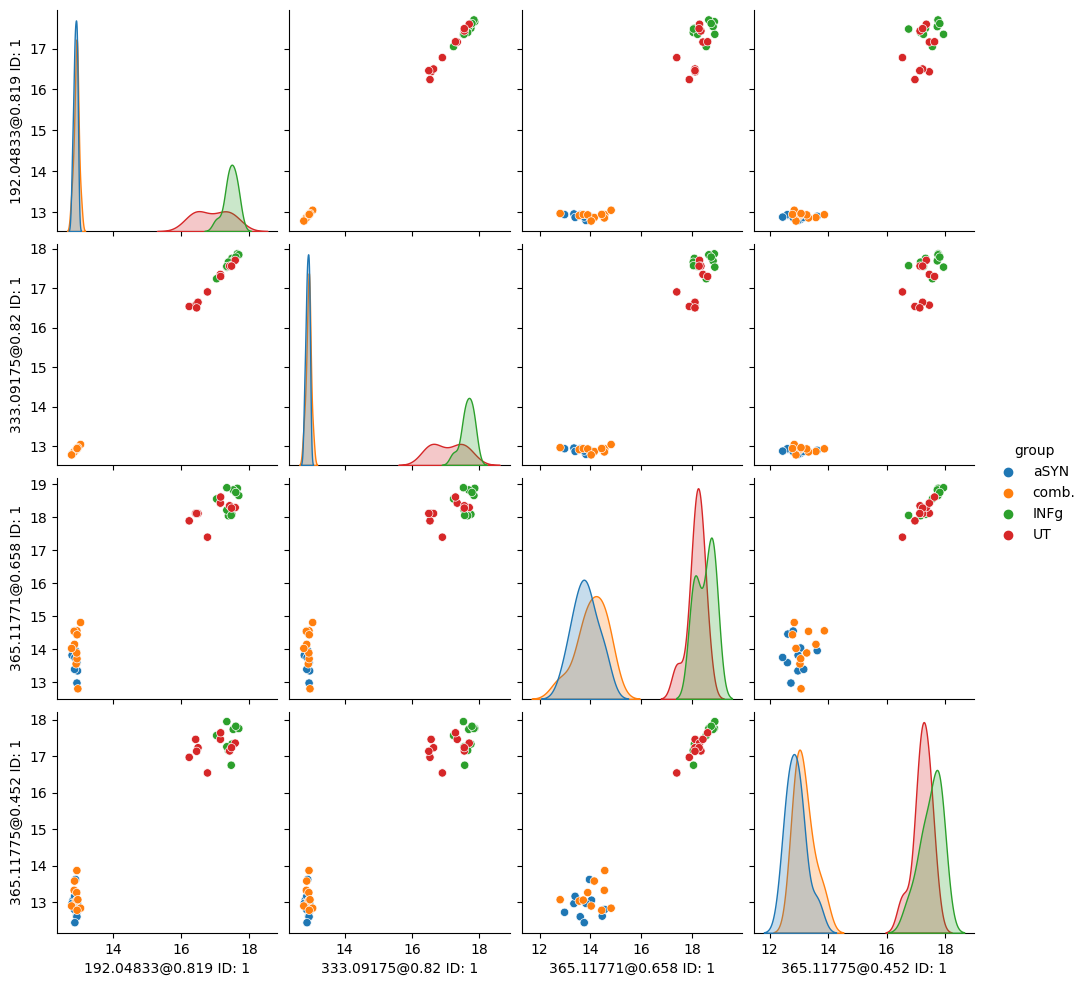

In [170]:
complete_pairplot(df_cluster, group_col='group', kind='kde', palette=None)

### Visualize individual clusters

In [149]:
inds=np.argsort(labels_complete)
result = data_X.iloc[inds,:]
result.insert(loc=len(result.columns), column='labels_complete', value=labels_complete[inds])
luniq=np.unique(labels_complete[inds])

In [181]:
k = luniq[1]
#k=luniq[7]

cluster_ind = np.where(labels_complete[inds]==k)[0]
cluster_names = result.iloc[cluster_ind,0].to_numpy(dtype=str)
cluster_times = result.iloc[cluster_ind,5].to_numpy(dtype=float)
cluster_mass = result.iloc[cluster_ind,4].to_numpy(dtype=float)
cluster_masstimes = ["{}@{}".format(m,t) for m,t in zip(cluster_mass,cluster_times)]

cluster = result.iloc[cluster_ind,8:48].to_numpy(dtype=float).T

df_cluster = pd.DataFrame(cluster, columns = cluster_masstimes)
df_cluster['group']=groups.to_numpy(dtype=str)
print(cluster_times)

[6.208 6.205]


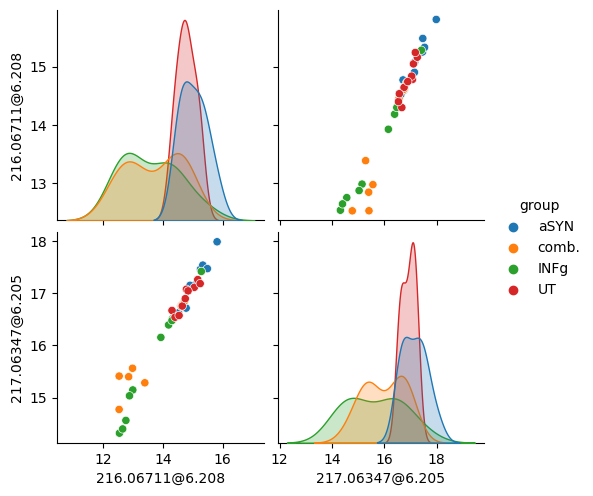

In [182]:
complete_pairplot(df_cluster, group_col='group', kind='kde', palette=None)

In [183]:
df_new.iloc[np.where(df_new[' clusterID']==k)[0],:]

,compound,clusterID,neg_cor_clusters,masstime,test,p_orig,p_FDR,p_Bonf,FC,ms,gaps1,gaps2
32,Ethyl 4-hydroxy-3-quinolinecarboxylate,2,,216.06711@6.208,aSYN--INFg,0.000732,0.036295,0.214553,1.445566,0.0,0,3
36,Diethyl (2-furylmethyl)phosphonate,2,,217.06347@6.205,aSYN--comb.,0.001024,0.044545,0.300148,1.160236,0.0,0,0


In [184]:
cluster_names

array(['Ethyl 4-hydroxy-3-quinolinecarboxylate',
       'Diethyl (2-furylmethyl)phosphonate'], dtype='<U38')

In [185]:
cluster_masstimes

['216.06711@6.208', '217.06347@6.205']

In [186]:
mts, ps, ts, es = extract_pvalues(df_s,cluster_masstimes, pvalue_col=' p_FDR',head='')
display_pvalues(mts, ps, ts, es, tle)

mediumhilicneg
-----------------------
Peak: 216.06711@6.208
P-values: [0.03629473479808]
Tests: ['aSYN--INFg']
Effects: [1.44556605107832]
-----------------------
Peak: 217.06347@6.205
P-values: [0.04454489133914]
Tests: ['aSYN--comb.']
Effects: [1.16023563593516]


In [253]:
def probabilistic_pca(X, q=1, shift_and_scale=False):
    assert q > 0, "q must be greater than 0"
    assert q < X.shape[1], "q must be less than the number of features"
    
    C = np.cov(X.T)
    mu = np.mean(X, axis=0)
    # use linalg.eigh to get the eigenvalues and eigenvectors of C
    # the eigenvalues are sorted in descending order
    eigvals, eigvecs = np.linalg.eigh(C)
    # get the indices of the largest q eigenvalues
    indices = np.argsort(eigvals)[::-1]
    # sort the eigenvectors according to the indices
    eigvecs = eigvecs[:,indices]
    
    # get the eigenvalues corresponding to the indices
    eigvals = eigvals[indices]
    # calculate the ML estimate of the variance
    sigma_ML = np.sum(eigvals[q:])/(X.shape[1]-q)
    W = eigvecs[:,:q]@np.diag(np.sqrt(eigvals[:q]-sigma_ML))
    M = W.T@W + sigma_ML*np.eye(W.shape[1])
    
    mu_posterior = np.linalg.inv(M)@W.T@(X-mu).T
    sigma_posterior = sigma_ML*np.linalg.inv(M)
    if q==1:
    # calcute correlation between first feature and the mu_posterior
        corr = np.corrcoef(mu_posterior, X[:,0])[0,1]
        if corr < 0:
            mu_posterior = -mu_posterior
        print('Correlation between the first feature and the posterior mean:', np.abs(corr))
    if shift_and_scale:
        # scale by joint data variance
        mu_posterior *= np.sqrt(np.var(X, axis=0).mean()/X.shape[1])
        mu_posterior += mu.mean()
        
    
    return mu_posterior.reshape(-1), sigma_posterior

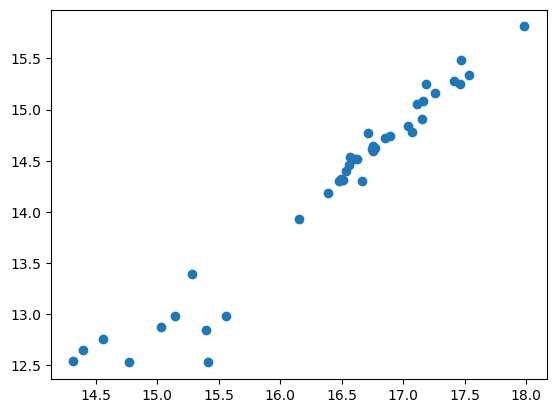

In [254]:
plt.scatter(cluster[:,1],cluster[:,0])

Correlation between the first feature and the posterior mean: 0.9941510481786755


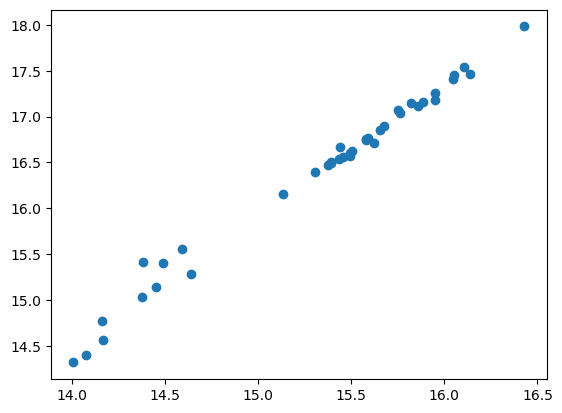

In [255]:
plt.scatter(probabilistic_pca(cluster, q=1, shift_and_scale=True)[0],cluster[:,1])

In [256]:
representative, sigma = probabilistic_pca(cluster, q=1, shift_and_scale=True)
repX, repY = representative[:10], representative[10:20]
# run welch's t-test
stats.ttest_ind(repX, repY, equal_var=False)

Correlation between the first feature and the posterior mean: 0.9941510481786755


TtestResult(statistic=4.120483716432457, pvalue=0.0010715708226347387, df=13.78908110563491)

In [261]:
np.var(repX), np.var(repY), np.var(representative), sigma[0,0]

(0.0893939372902909,
 0.3102325847914315,
 0.4128855360207785,
 0.011983262052545499)

In [239]:
repX0, repY0=cluster[:10,0], cluster[10:20,0]
pval0 = stats.ttest_ind(repX0, repY0, equal_var=False)[1]
stats.ttest_ind(repX0, repY0, equal_var=False)

TtestResult(statistic=4.078851845796088, pvalue=0.0013313339553886105, df=12.8633910160592)

In [240]:
repX1, repY1=cluster[:10,1], cluster[10:20,1]
pval1 = stats.ttest_ind(repX1, repY1, equal_var=False)[1]
stats.ttest_ind(repX1, repY1, equal_var=False)

TtestResult(statistic=4.072128677325921, pvalue=0.0010243966994958654, df=14.820979392172557)

In [248]:
# geomentric mean of the p-values
np.sqrt(pval0*pval1)

0.001167824520134283

In [247]:
# harmonic mean of p-values 0 and 1
2/(1/pval0 + 1/pval1)

0.0011578693064922987

## Alternative approach using a mixture of Von Mises Fisher distributions, or spherical kmeans 

In [18]:
x=X_std.T

In [63]:
K=len(luniq)
xinit=x[np.random.choice(range(x.shape[0]),K),:]
centroids, dist, predictions = kmeans_spherical_v2(x, K, 1000, xinit)
centroids.shape[0]

21

In [64]:
NMI(labels_complete, predictions)

0.8599101694009053

In [32]:
centroids

array([[ 0.01853818,  0.06509062, -0.13553732, ..., -0.20259301,
        -0.15869412, -0.07491774],
       [-0.17975048, -0.1708161 , -0.16062406, ..., -0.14200062,
        -0.16085002, -0.14028602],
       [-0.22319731, -0.26071553, -0.06794866, ..., -0.06541877,
        -0.18030832, -0.02717054],
       ...,
       [-0.05507034, -0.09557675, -0.05361294, ..., -0.16481921,
        -0.14631325, -0.1359418 ],
       [ 0.08880237,  0.14117861, -0.08396233, ..., -0.07063078,
        -0.09679427, -0.08632264],
       [-0.06300204, -0.10303122, -0.18884351, ..., -0.17182978,
        -0.02201925,  0.03062516]])

In [42]:
NMI(labels_complete, predictions)

0.8331836775826519

In [47]:
inds=np.argsort(predictions)
result = data_X.iloc[inds,:]
result.insert(loc=len(result.columns), column='labels_complete', value=predictions[inds])
luniq=np.unique(predictions[inds])

In [50]:
k=luniq[1]

cluster_ind = np.where(predictions[inds]==k)[0]
cluster_names = result.iloc[cluster_ind,0].to_numpy(dtype=str)
cluster_times = result.iloc[cluster_ind,5].to_numpy(dtype=float)
cluster_mass = result.iloc[cluster_ind,4].to_numpy(dtype=float)
cluster_masstimes = ["{}@{}".format(m,t) for m,t in zip(cluster_mass,cluster_times)]

cluster = result.iloc[cluster_ind,8:48].to_numpy(dtype=float).T

df_cluster = pd.DataFrame(cluster, columns = cluster_masstimes)
df_cluster['group']=groups.to_numpy(dtype=str)
print(cluster_times)

[0.603 0.604 0.603]


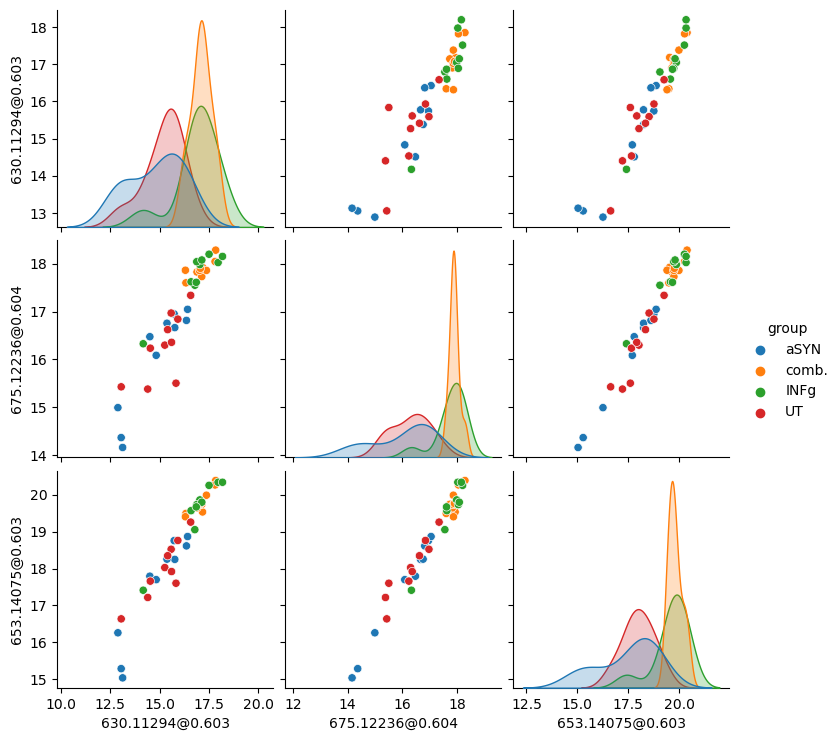

In [51]:
complete_pairplot(df_cluster, group_col='group', kind='kde', palette=None)

### Compile the data with column for cluster labels

In [56]:
colnames=['labels']
colnames.extend(list(df_GF.iloc[2,:8]))
colnames.extend(list(groups))

In [58]:
data_with_labels = data_X.copy()
data_with_labels.insert(0, 'labels', labels_complete)
data_with_labels.columns=colnames
data_with_labels.head(2)

,labels,Name,Formula,Annot. DeltaMass [ppm],Calc. MW,m/z,RT [min],MS2,Reference Ion,aSYN,...,UT,UT,UT,UT,UT,UT,UT,UT,UT,UT
5,7,Reduced Glutathione,C10 H17 N3 O6 S,2,307.08442,306.07714,0.609,No MS2,[M-H]-1,22.156488084284803,...,22.71064097411695,23.75006289012101,23.370456794721267,23.28077131792212,23.620124399449285,22.869467356729697,23.782858059823745,24.00450069571074,23.412271201777354,23.32474683416169
7,1,Reduced Glutathione,C10 H17 N3 O6 S,1.74,307.08434,306.07706,0.913,No MS2,[M-H]-1,23.251795601807505,...,23.348650364674228,24.145229476313656,23.98321476112747,23.632515750033832,23.934705257679628,23.114699904857332,24.167128122163657,24.346850456627738,23.616989477849803,23.821658754447014


In [79]:
def get_latents(model, names, topics=None, n_top_words=10):
    word_dict = {}
    if topics is None:
        topics = ['Topic{}'.format(str(i)) for i in range(model.components_.shape[0])]
    feature_names = names
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        #top_features_ind = np.flip(top_features_ind)
        top_features = [feature_names[i] for i in top_features_ind]
        word_dict[topics[topic_idx]] = top_features

    return pd.DataFrame(word_dict)

In [63]:
features = data_with_labels.iloc[:,9:].to_numpy().T

In [87]:
# features = obs x compounds ~ abs x latents x (features x latents).T
lsi_model = TruncatedSVD(n_components=2).fit(features)
lsi_features = lsi_model.transform(features)

In [92]:
lsi_model_left = TruncatedSVD(n_components=2).fit(features.T)
lsi_features_left = lsi_model_left.transform(features.T)

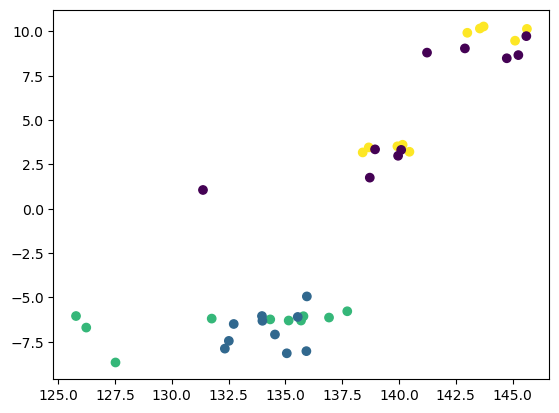

In [88]:
plt.scatter(lsi_features[:,0],lsi_features[:,1], c=LabelEncoder().fit_transform(groups))

In [90]:
get_latents(lsi_model, labels_complete, n_top_words=10)

,Topic0,Topic1
0,1,4
1,7,1
2,5,16
3,5,17
4,3,12
5,12,14
6,19,14
7,7,12
8,3,13
9,10,2


In [89]:
get_latents(lsi_model, list(data_with_labels.Name), n_top_words=10)

,Topic0,Topic1
0,Reduced Glutathione,"[(2R,3S,4R,5R)-5-(6-Amino-9H-purin-9-yl)-3,4-d..."
1,Reduced Glutathione,NaN
2,NaN,"stigmastane-3beta,5alpha,6beta-triol"
3,NaN,NaN
4,O-{[(2R)-3-(Henicosanoyloxy)-2-hydroxypropoxy]...,"(19R)-25-Amino-22-hydroxy-22-oxido-17,21,23-tr..."
5,NaN,NaN
6,NaN,Dilauryl citrate
7,NaN,1-hexadecanoyl-2-[(Z)-octadec-9-enoyl]-sn-glyc...
8,1-Oleoyl-2-hydroxy-sn-glycero-3-PE,NaN
9,NaN,NaN


In [96]:
get_latents(lsi_model_left, list(groups), n_top_words=20)

,Topic0,Topic1
0,comb.,aSYN
1,INFg,UT
2,INFg,UT
3,comb.,UT
4,INFg,UT
5,comb.,UT
6,comb.,aSYN
7,comb.,UT
8,INFg,UT
9,INFg,aSYN
